# Système de recommendation : premiers pas NLTK 

Ce notebook a pour but de présenter les premières observations que l'on obtient en regardant les commentaires des utilisateurs laissés aux jeux dans la base de donnée avis_clean.csv. Il se découpe en deux parties : le nettoyage (récupération des BDD pertinentes) et exposition des histogrammes.

In [ ]:
import pandas as pd
import numpy as np
from reco_systems.filter import filter_df
import langid
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.tag import StanfordPOSTagger

from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

FR_stopwords = stopwords.words("french")

In [2]:
import os 
# Setup for lemmatisation
jar = '/Users/bsh2022/Study/L3/Projet_recherche/stanford-postagger-full-2020-11-17/stanford-postagger.jar'
model = '/Users/bsh2022/Study/L3/Projet_recherche/stanford-postagger-full-2020-11-17/models/french-ud.tagger'

os.environ['JAVAHOME'] = '/Library/Java/JavaVirtualMachines/jdk-20.jdk/Contents/Home' 

In [3]:
from unidecode import unidecode # remove french accents

In [4]:
# for word in FR_stopwords:
#     if "que" in word:
#         print(word)
#FR_stopwords += ['donc', 'alors', 'que', 'qui']

In [5]:
folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", names=["Username", "User id"])

min_reviews = 10
rev_filter = filter_df(avis_clean, min_reviews)

df = rev_filter[['Game id', 'User id', 'Rating', 'Comment title', 'Comment body']].copy()

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [6]:
# .apply(unidecode) in the end if necessary (delete french accents)
text = rev_filter[["Comment title", "Comment body"]].apply(lambda x : " ".join(x.values.astype(str)), axis=1).str.lower().apply(unidecode)
text.head(10)

0     voyages sur les ailes des papillons lorsque le...
1     le festival de michoacan comment continuer apr...
2     vivez la migration des monarques vin d'jeu: av...
3     manque un peu de souffle mariposas est plutot ...
4     beau et doux et rapide mariposas est un jeu ou...
6     peut-etre pas uniquement familial il est tres ...
7     mysterium sans ses defauts vin d'jeu: ce << no...
8     chapeau l'artiste en famille nous avons bien p...
9     parc a theme j'ai eu l'occasion de jouer a des...
11    mysterium light fan de la serie mysterium c'es...
dtype: object

In [7]:
rev_filter[["Comment title", "Comment body"]].head(5)

,Comment title,Comment body
0,Voyages sur les ailes des papillons,"Lorsque le jeu est jeu, bon, réflexif, joli po..."
1,le festival de Michoacan,Comment continuer après un mega hit ? Simpleme...
2,Vivez la migration des monarques,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ..."
3,Manque un peu de souffle,Mariposas est plutôt beau avec un grand platea...
4,Beau et Doux et Rapide,Mariposas est un jeu ou la tension va s'exacer...


### Remove punctuation

In [8]:
#punc_to_delete = string.punctuation.replace("\'", "") # ' can have meaning 
punc_to_delete = string.punctuation
punc_to_delete

trans_table = str.maketrans(punc_to_delete, " " * len(punc_to_delete))
text = text.str.translate(trans_table)

### Remove French stopwords

In [9]:
text = text.apply(lambda x : " ".join([word for word in x.split() if word not in FR_stopwords]))

### Tokenization

In [10]:
text_df = text.to_frame().rename(columns={0 : "Text"})
text_df["Tokens"] = text.apply(lambda row: nltk.word_tokenize(row))
# text_df

In [11]:
tokens = text_df[["Tokens"]]
tokens

,Tokens
0,"[voyages, ailes, papillons, lorsque, jeu, jeu,..."
1,"[festival, michoacan, comment, continuer, apre..."
2,"[vivez, migration, monarques, vin, jeu, maripo..."
3,"[manque, peu, souffle, mariposas, plutot, beau..."
4,"[beau, doux, rapide, mariposas, jeu, tension, ..."
...,...
142459,"[piou, boum, badaboum, crac, re, piou, petit, ..."
142460,"[star, wars, revisite, jeu, vaisseau, spaciaux..."
142461,"[piou, piou, mag, blast, jeu, rapide, drole, s..."
142462,"[peewww, peeeww, mort, pu, jouer, a, 2, moyen,..."


In [12]:
words = tokens.explode("Tokens")
words

,Tokens
0,voyages
0,ailes
0,papillons
0,lorsque
0,jeu
...,...
142465,a
142465,voir
142465,partie
142465,8


In [13]:
words["Len"] = words["Tokens"].str.len()
words = words[words["Len"] > 2]
words.size

12360512

In [14]:
# pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8')
# lim_tokens = tokens[:100]
# lim_tokens["Tokens"].apply(lambda row : pos_tagger.tag(row))

In [15]:
stemmer = FrenchStemmer(ignore_stopwords=True)
words["Stems"] = words["Tokens"].apply(stemmer.stem)
words["Len"] = words["Tokens"].str.len()

C:\Users\arlyc\AppData\Local\Temp\ipykernel_21008\2844154888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words["Stems"] = words["Tokens"].apply(stemmer.stem)
C:\Users\arlyc\AppData\Local\Temp\ipykernel_21008\2844154888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words["Len"] = words["Tokens"].str.len()


In [16]:
words = words[words["Len"] > 1]

In [17]:
words[words["Len"] == 2]["Stems"].unique()

array([], dtype=object)

In [25]:
freq = words["Stems"].value_counts().to_frame().reset_index()
freq["tf"] = freq["count"] / freq["count"].sum()
freq


,Stems,count,tf
0,jeu,224257,3.628604e-02
1,plus,90741,1.468240e-02
2,part,79338,1.283733e-02
3,tre,71638,1.159143e-02
4,tout,70762,1.144969e-02
...,...,...,...
70159,attaquebon,1,1.618056e-07
70160,partiedefausseechang,1,1.618056e-07
70161,joueurssystem,1,1.618056e-07
70162,piuou,1,1.618056e-07


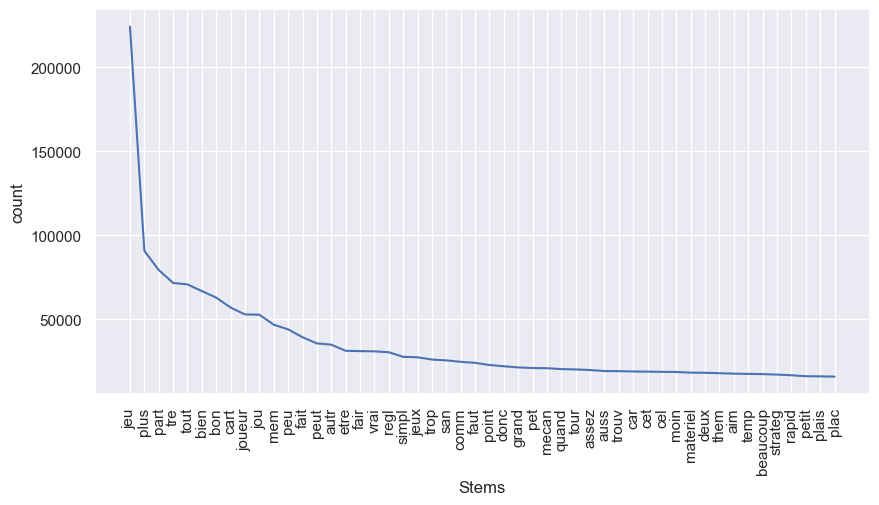

In [19]:
sns.set_theme(rc={'figure.figsize' : (10, 5)})
lim_freq = freq[:50]
ax = sns.lineplot(data=lim_freq, x="Stems", y="count")
ax.tick_params(axis='x', rotation=90)

## Correcting grammar

In [20]:
# .apply(unidecode) in the end if necessary (delete french accents)
text3 = rev_filter[["Comment title", "Comment body"]].apply(lambda x : " ".join(x.values.astype(str)), axis=1).str.lower().apply(unidecode)
text3 = text3.to_frame()
text3[0][0]

KeyboardInterrupt: 

## TF-IDF

In [ ]:
text2_df = pd.read_csv("generated_data/comments_stemmed.csv",index_col=0)
text2_df['Tokens'] = text2_df['Comment stemmed'].apply(lambda row: nltk.word_tokenize(row))
text2_df = text2_df.drop("Comment stemmed", axis=1)

def spell_check(word):
    spell = SpellChecker('fr')

    lang,_ = langid.classify(word)
    print("Mot :", word, "langue : ", lang)
    if lang !='fr':
        print("Correction proposée : ", spell.correction(word))
        return spell.correction(word)
    else : return word

print(text2_df.shape)
text2_df = text2_df.explode("Tokens").reset_index()
text2_df
tokens2 = pd.DataFrame(np.unique(text2_df['Tokens'].to_numpy()),columns=['Tokens'])
print(tokens2[len(tokens2["Tokens"]) ==2].shape)
#gb_t2 = text2_df.groupby("Tokens").count()
print(tokens2.shape)
#v_spellcheck = np.vectorize(spell_check)
#tokens2['Correct_spell'] = v_spellcheck(tokens2['Tokens'])


(96533, 1)
(58701, 1)
Mot : ab langue :  en
Correction proposée :  a
Mot : ab langue :  en
Correction proposée :  a
Mot : abacus langue :  en
Correction proposée :  abus
Mot : abacuspiel langue :  en
Correction proposée :  None
Mot : abais langue :  lt
Correction proposée :  avais
Mot : abaisent langue :  fi
Correction proposée :  abaissent
Mot : abalon langue :  en
Correction proposée :  salon
Mot : abalonegam langue :  pl
Correction proposée :  None
Mot : aband langue :  es
Correction proposée :  quand
Mot : abandon langue :  es
Correction proposée :  abandon
Mot : abandonc langue :  es
Correction proposée :  abandon
Mot : abandonent langue :  es
Correction proposée :  abandonnent
Mot : abandonwar langue :  es
Correction proposée :  abandonner
Mot : abaqu langue :  en
Correction proposée :  abattu
Mot : abasourd langue :  en
Correction proposée :  abasourdi
Mot : abat langue :  en
Correction proposée :  abat
Mot : abatag langue :  en
Correction proposée :  abattu
Mot : abatent langue

KeyboardInterrupt: 

In [ ]:
tokens2['Len'] = tokens2["Tokens"].str.len()
print(tokens2[tokens2['Len'] ==3].shape)

(2319, 2)


In [ ]:
# TF-IDF Vectorizer
corpus = text2_df['Comment stemmed'].to_numpy()
v = TfidfVectorizer()
transformed_output = v.fit_transform(corpus)

In [ ]:
data_tf_idf = tokens.explode(['Tokens']).reset_index()
vect_idf = np.vectorize(lambda x : v.idf_[v.vocabulary_.get(x)] if v.vocabulary_.get(x) else None)
vect_indx = np.vectorize(lambda word : v.vocabulary_.get(word) if v.vocabulary_.get(word) else None)


to = transformed_output.toarray()
def tf(doc,word):
    print(doc,word)
    indx = v.vocabulary_.get(word)
    if indx : return transformed_output.toarray()[doc][indx]
    else : return None


vect_tf = np.vectorize(tf)
data_tf_idf['IDF'] = vect_idf(data_tf_idf['Tokens'].to_numpy())
data_tf_idf['TF-doc'] = vect_tf(data_tf_idf['index'].to_numpy(),data_tf_idf['Tokens'].to_numpy())


MemoryError: Unable to allocate 42.2 GiB for an array with shape (96533, 58700) and data type float64